# Bayesian Inference Assisted Energy Model Calibration

# Import Libraries and Modules

In [1]:
import os
# os.chdir(os.path.join(os.getcwd(), 'src'))

import time
import pandas as pd
import numpy as np
import arviz as az
import multiprocessing as mp
from functools import partial
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.metrics import r2_score
try:
    import inputs 
except:
    import src.inputs as inputs
try:
    import paths 
except:
    import src.paths as paths
try:
    import plots 
except:
    import src.plots as plots

from run_DIBS import run_model
from SensitivityAnalysis import find_converged_sa_sample_size
from run_SA import run_SA
from GaussianProcesses import perform_gp_convergence
from run_GP_samples import sample_gp
from run_GP_train import train_gp
from BayesianCalibration import run_calibration
from multisimulationFunction import run_simulation


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Surpress outputs
import warnings
import theano
import logging
from contextlib import redirect_stdout

# Suppress Theano warnings
theano.config.warn.rounding = 'ignore'

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Adjust logging level
logging.getLogger("pymc3").setLevel(logging.ERROR)

In [3]:
def calculate_cvrmse_r2(measured, simulated):
    '''Calculate CV(RMSE) and R2 for a single simulation run.'''
    rmse = np.sqrt(np.mean((simulated - measured)**2))
    cvrmse = (rmse / np.mean(measured)) * 100
    r2 = r2_score(measured, simulated)
    return cvrmse, r2


# User Inputs

In [3]:
''' REQUIRED INPUTS '''
scr_gebaeude_id = 30034001          # Building ID
calib_type = 'TRY'                  # AMY: Actual Meteorological Year, TRY: Test Reference Year (works only for Germany)
output_resolution = None            # Time resolution for the metered data and calibration: Y = Yearly, M = Monthly, W = Weekly, etc, None = for TRY version
climate_file = None                 # Name of the climate file 'AMY_2010_2022.epw'

''' OPTIONAL INPUTS '''
num_bc_param = 5                    # Number of model parameters to be calibrated
SA_Convergence_Required = 'Y'       # Preference to run automatized convergence check for Sensitivity Analysis
SA_sampling_lowerbound = 4          # Minimum number of samples (N) for Sensitivity Analysis ((N*(2D+2))). D=Dimensions, number of parameters
SA_sampling_upperbound = 9          # Maximum number of samples for Sensitivity Analysis (This limit prevents excessively long runtimes if the sensitivity index parameter order does not converge)
GP_Convergence_Required = 'Y'       # Preference to run automatized convergence check for meta-model creation
min_gp_samples = 10                 # Minimum number of samples for meta-model training
max_gp_samples = 200                # Maximum number of samples for meta-model training
step_gp = 2                         # Increase in sample size for each new meta-model training
rmse_threshold = 0.0007             # RMSE criteria for the meta-model
gp_test_size = 25/100               # Proportion of samples for GP to be used for the evaluation of the meta-model
training_ratio = 75                 # Percentage of observed data to be used for the calibration
draws, tune, chains = 100, 200, 4   # Bayesian Calibration parameters



# Import Data 

In [4]:
''' IMPORT DATA '''
metered=pd.read_excel(os.path.join(paths.DATA_DIR, 'HeatEnergyDemand_{}_{}.xlsx'.format(scr_gebaeude_id, output_resolution)), index_col=0)
nr_train_data = round(metered[1:].shape[0]*training_ratio/100)
start_time_cal, end_time_cal = metered.index[0].strftime('%Y-%m-%d %H:%M:%S'), metered.index[nr_train_data].strftime('%Y-%m-%d %H:%M:%S')
start_time, end_time = metered.index[0].strftime('%Y-%m-%d %H:%M:%S'), metered.index[-1].strftime('%Y-%m-%d %H:%M:%S')
print(f'Metered data from period {start_time} to {end_time}. \nThe time series used for the calibration ends at {end_time_cal} \nThe remaining time series is used for the evaluation of the calibrated model.')

''' (0) Process Controll File'''
df = pd.DataFrame()
df['Name'] = ['Step done', 'Duration time in seconds', 'Other info', 'Other info', 'Other info', 'Other info', 'Other info', 'Other info']
ctrl_file = os.path.join(paths.CTRL_DIR, f'process_intermittent_check_{scr_gebaeude_id}_{calib_type}_{output_resolution}_{str(training_ratio)}.xlsx')
df.to_excel(ctrl_file)


Metered data from period 2010-01-01 00:00:00 to 2017-12-31 23:00:00. 
The time series used for the calibration ends at 2015-12-31 23:00:00 
The remaining time series is used for the evaluation of the calibrated model.


# Framework

### 1 Model Simulation Prior Calibration

Computational time for DIBS model to run is 2.65 seconds (0.04 minutes)


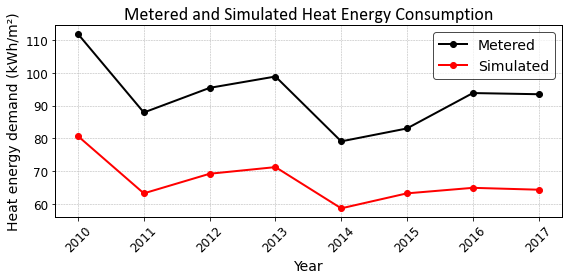

In [6]:
''' (1) DIBS Simulation '''
start_calc = time.time()

HeatingEnergy_sum = run_model(scr_gebaeude_id, 
                            climate_file, 
                            start_time, 
                            end_time, 
                            output_resolution, 
                            training_ratio)   

end_calc = time.time()
if output_resolution == None:
    HeatingEnergy_sum = HeatingEnergy_sum.tolist()
else: 
    HeatingEnergy_sum = HeatingEnergy_sum['HeatingEnergy'].values.tolist()

df['DIBS'] = ['DIBS simulation is working', end_calc-start_calc, 'Uncalibrated sim result, kWh: ', f'{HeatingEnergy_sum}', '-', '-', '-', '-']
df.to_excel(ctrl_file, index=False)

# Plot
plots.Plot_Model(scr_gebaeude_id, output_resolution, training_ratio)


### 2 Sensitivity Analysis of Model Parameters

Computational time for DIBS model to run is 2.75 seconds (0.05 minutes)
14
Generated 704 parameter combinations for 16 samples. Cores allocated for simulation are 14
Files_written 16
S1 estimates written 16
Sampling done  16
Sample Size: 16
Top 5 ST Parameters: [13 19 14 21 20]
Generated 1408 parameter combinations for 32 samples. Cores allocated for simulation are 14
Files_written 32
S1 estimates written 32
Sampling done  32
Sample Size: 32
Top 5 ST Parameters: [13 19 14 20 21]
Generated 2816 parameter combinations for 64 samples. Cores allocated for simulation are 14
Files_written 64
S1 estimates written 64
Sampling done  64
Sample Size: 64
Top 5 ST Parameters: [13 19 14 20 21]
Computational time for the Sensitivity Analysis to perform is 1866.94 seconds (31.12 minutes)
The sample size for which the ranking of the top five parameters doesn't change compared to the previous sample size is 64.


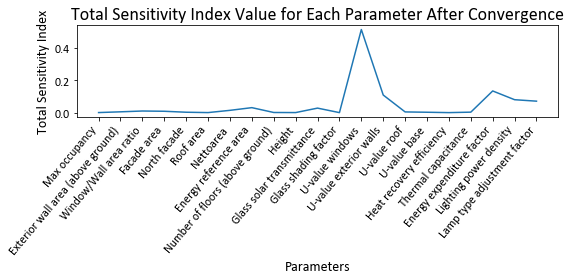

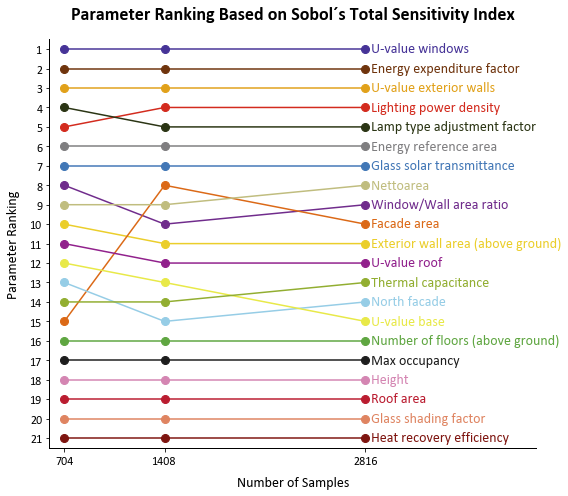

In [7]:
''' (2) Sensitivity Analysis'''
if SA_Convergence_Required == 'Y':             
    num_samples_sa, sa_converged, calc_time_SA, sample_sizes, total_Si = find_converged_sa_sample_size(scr_gebaeude_id, 
                                                                                                            calib_type, 
                                                                                                            climate_file, 
                                                                                                            start_time_cal, 
                                                                                                            end_time_cal, 
                                                                                                            output_resolution, 
                                                                                                            training_ratio,  
                                                                                                            SA_sampling_lowerbound, 
                                                                                                            SA_sampling_upperbound)

    ''' No automatized convergence '''
else:
    sa_converged = 0
    num_samples_sa = 32     # Default number of samples for determination of most sensible parameters.
    total_SI, calc_time_SA = run_SA(scr_gebaeude_id, num_samples_sa, climate_file, start_time_cal, end_time_cal, output_resolution, training_ratio) 
        
df['SA'] = ['SA is done', f'Convergence time: {calc_time_SA}', f'Num samples: {num_samples_sa}', f'SA Converged: {sa_converged}', f'SA_Convergence_Required: {SA_Convergence_Required}', '-', '-', '-']
df.to_excel(ctrl_file, index=False)

# Plot
plots.Plot_SA(scr_gebaeude_id, calib_type, output_resolution, training_ratio, sample_sizes, num_samples_sa, total_Si)

### 3 Surrogate model creation with Gaussian Process Regression

In [8]:
''' (3) Meta-model '''
if GP_Convergence_Required == 'Y':
    best_result, best_kernel_path, best_samples_df_path, conv_time = perform_gp_convergence(scr_gebaeude_id, climate_file, output_resolution, calib_type, 
                                                                                            start_time_cal, end_time_cal, min_gp_samples, max_gp_samples, 
                                                                                            num_bc_param, num_samples_sa, step_gp, rmse_threshold, 
                                                                                            gp_test_size, training_ratio)
    best_rmse_norm = best_result['RMSE_NORM']
    kernel_index = best_result['Kernel_Index']
    kernel = best_result['Kernel']
    num_samples_gp = best_result['Num_Samples_GP']

    df['GP convergence'] = ['GP is done', conv_time, f'num_samples_gp: {num_samples_gp}', f'num_bc_param: {num_bc_param}', f'num_samples_sa: {num_samples_sa}', f'climate_file: {climate_file}', f'output_resolution: {output_resolution}', '-']
    df.to_excel(ctrl_file, index=False)

    # Plot
    plots.Plot_GP(best_result, scr_gebaeude_id, output_resolution, num_bc_param, training_ratio)

    ''' No automatized convergence '''
else:
    num_samples_gp = 80     # Default number of samples for the training & testing of the meta-model.
    kernel, kernel_index = 1 * RationalQuadratic(), 1   # Default Kernel

    # Sampling for the Gaussian Processes
    start = time.time()
    samples_df, calc_time = sample_gp(scr_gebaeude_id, num_bc_param, num_samples_sa, num_samples_gp, climate_file, start_time_cal, end_time_cal, output_resolution, training_ratio)
    finish = time.time()
    df['GP sample'] = ['GP samples is done', finish-start, f'num_samples_gp: {num_samples_gp}', f'num_bc_param: {num_bc_param}', f'num_samples_sa: {num_samples_sa}', f'climate_file: {climate_file}', f'start_time, end_time: {start_time}, {end_time}', f'output_resolution: {output_resolution}']
    df.to_excel(ctrl_file, index=False)
        
    # Training the meta-model
    start = time.time()
    kernel_trained, mse, mae, rmse, r2, sigma, y_test_mean, mape = train_gp(scr_gebaeude_id, num_bc_param, kernel, kernel_index, num_samples_gp, gp_test_size, output_resolution, training_ratio) 
    finish = time.time()
    df['GP train'] = ['GP train is done', finish-start, f'bc_param: {num_bc_param}, training_ratio: {training_ratio}, samples: {num_samples_gp}', f'Kernel: {kernel_trained}', f'Kernel index: {kernel_index}, GP test size: {gp_test_size}', f'MAPE: {mape} / MSE: {mse} / RMSE: {rmse} / MAE: {mae}', f'r2-score: {r2}', f'std of prediction: {sigma}']
    df.to_excel(ctrl_file, index=False)

Total CPU cores: 16
Cores to be used for processing: 14

RMSE threshold of 0.0007 and R² > 0.99 reached!
Computational time required for Meta-model generation is 821.72 seconds (13.70 minutes)


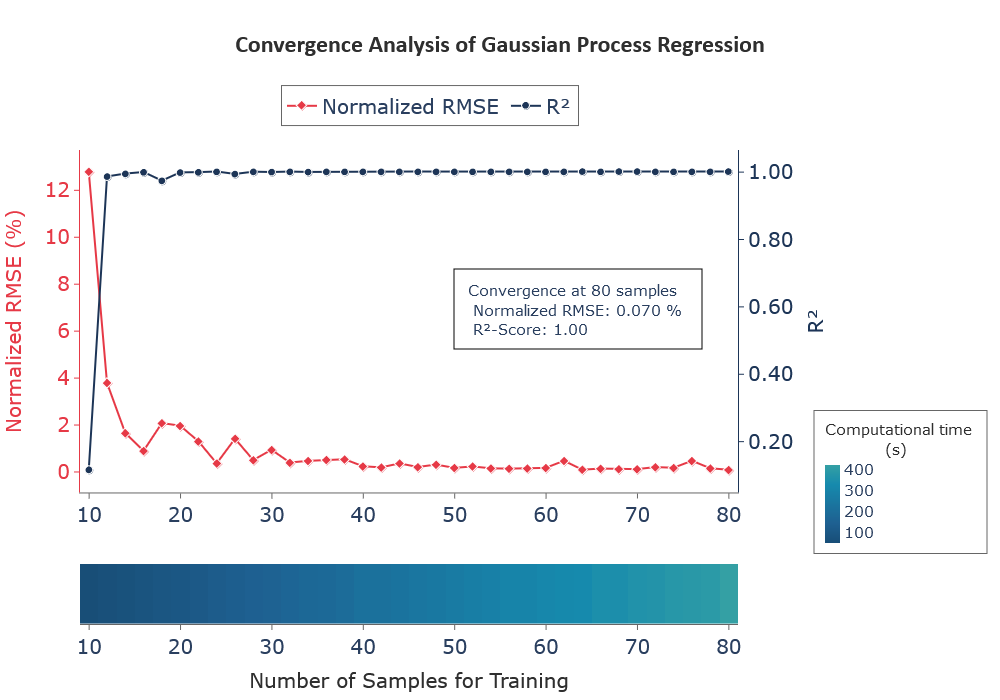

The meta-model is only trained for the years that are used for the calibration


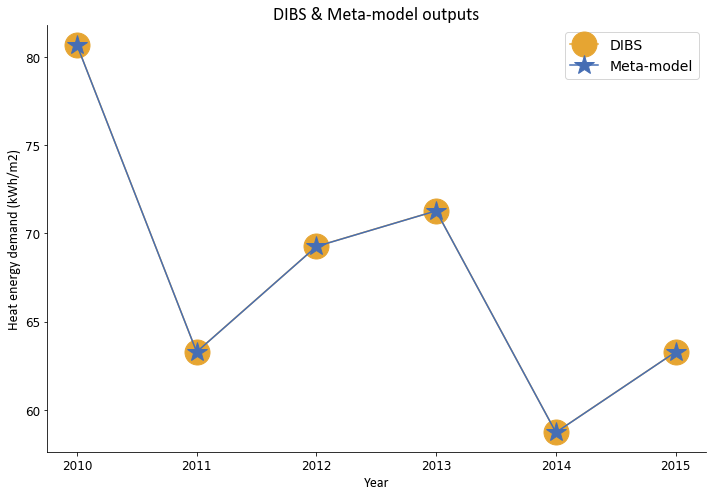

In [5]:
# Plot Meta-model training
from IPython.display import Image
display(Image(filename=os.path.join(paths.PLOTS_DIR, f'{scr_gebaeude_id}/3a_GP_Conv_{scr_gebaeude_id}_{output_resolution}_{training_ratio}.png'),width=710, height=500))

# Plot Meta-model
trained_meta_model = 'Trained_GP_80_1_kernel.pkl'
samples_meta_model = 'Indata_GP_75_80_samples.pkl'
print('The meta-model is only trained for the years that are used for the calibration')
plots.Plot_MetaModel(scr_gebaeude_id, num_bc_param, output_resolution, training_ratio, trained_meta_model, samples_meta_model, end_time_cal)

### 4 Bayesian Calibration


Number of draws: 100, Number of tunes: 200
R-hat scores: [1.01 1.34 1.26 1.28 1.34 1.22]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 200, and number of tunes: 400
Computational time for the Bayesian calibration of the model is 32.39 seconds (0.54 minutes)


The estimated number of effective samples is smaller than 200 for some parameters.



Number of draws: 200, Number of tunes: 400
R-hat scores: [1.   1.17 1.26 1.25 1.06 1.07]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 400, and number of tunes: 800
Computational time for the Bayesian calibration of the model is 68.72 seconds (1.15 minutes)


The estimated number of effective samples is smaller than 200 for some parameters.



Number of draws: 400, Number of tunes: 800
R-hat scores: [1.01 1.06 1.19 1.08 1.06 1.08]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 800, and number of tunes: 1600
Computational time for the Bayesian calibration of the model is 126.14 seconds (2.10 minutes)


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



Number of draws: 800, Number of tunes: 1600
R-hat scores: [1.   1.02 1.06 1.02 1.05 1.01]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 1600, and number of tunes: 3200
Computational time for the Bayesian calibration of the model is 224.83 seconds (3.75 minutes)


There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



Number of draws: 1600, Number of tunes: 3200
R-hat scores: [1.   1.03 1.02 1.02 1.01 1.01]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 3200, and number of tunes: 6400
Computational time for the Bayesian calibration of the model is 464.72 seconds (7.75 minutes)


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.



Number of draws: 3200, Number of tunes: 6400
R-hat scores: [1.   1.02 1.01 1.01 1.02 1.01]
Sampling again as R-hat is greater than:  1.01
Increasing the number of draws: 6400, and number of tunes: 12800
Computational time for the Bayesian calibration of the model is 796.50 seconds (13.27 minutes)


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Converged with R-hat values: [1.   1.01 1.01 1.01 1.   1.  ]
Bayesian calibration converged at 12800 tunes and 6400 draws
Reading trace from: c:\Users\Kata\Desktop\caliblab\results\calibration\30034001\5_bc_param\75_obs_None_6400_12800_4.nc
Variables in trace: ['model_discrepancy', 'u_fen', 'heating_coefficient', 'u_aw', 'p_j_lx', 'k_L', 'error_obs', 'sim_result']
Applied name mapping: {'model_discrepancy': 'Model discrepancy', 'u_fen': 'U-value windows', 'heating_coefficient': 'Energy expenditure factor', 'u_aw': 'U-value exterior walls', 'p_j_lx': 'Lighting power density', 'k_L': 'Lamp type adjustment factor', 'error_obs': 'Error in measured data', 'sim_result': 'Simulation outputs'}


<Figure size 1728x216 with 0 Axes>

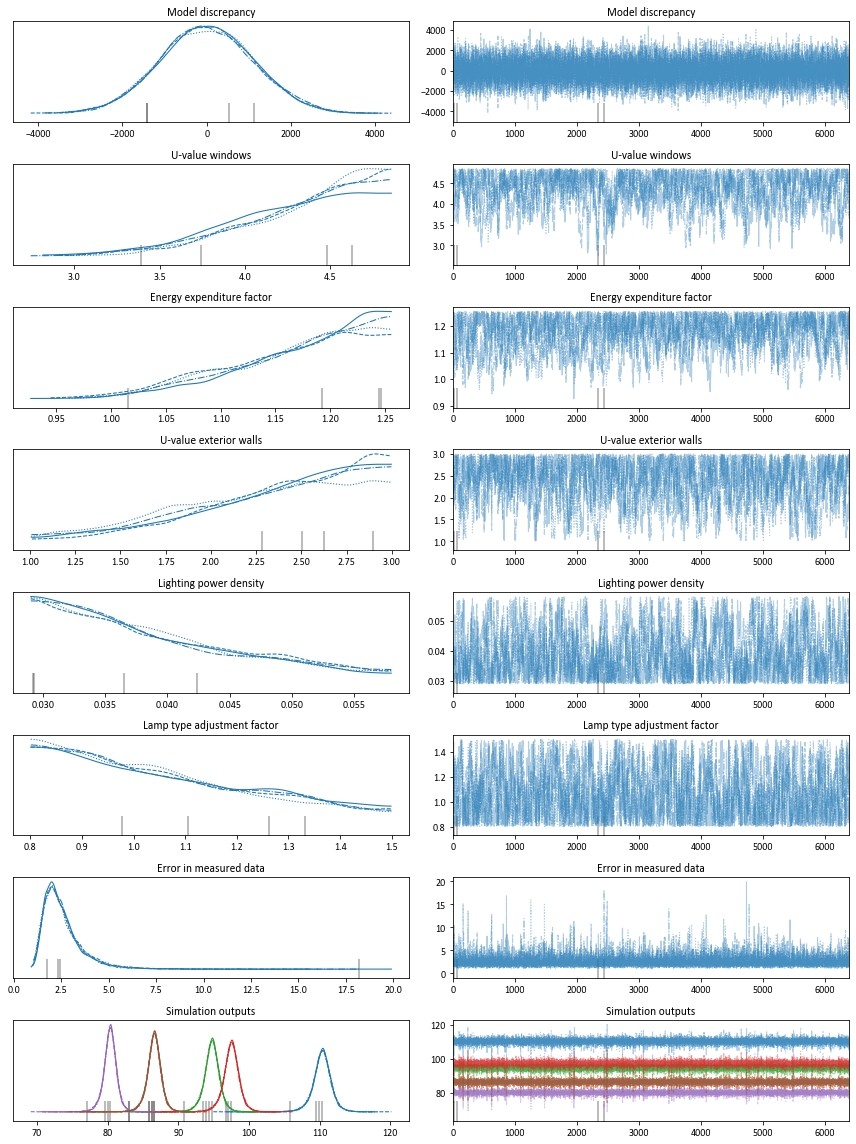

Plots and summary saved in: c:\Users\Kata\Desktop\caliblab\plots\30034001


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
model_discrepancy,3.164,1103.844,-2085.900,2054.751,8.206,7.498,18084.0,14275.0,1.00
u_fen,4.340,0.390,3.640,4.860,0.017,0.012,563.0,942.0,1.01
heating_coefficient,1.172,0.062,1.059,1.256,0.002,0.002,706.0,1134.0,1.01
u_aw,2.364,0.461,1.530,3.000,0.017,0.012,807.0,1120.0,1.01
p_j_lx,0.039,0.008,0.029,0.053,0.000,0.000,848.0,2021.0,1.00
k_L,1.061,0.187,0.800,1.397,0.007,0.005,904.0,2043.0,1.00
error_obs,2.589,1.152,1.125,4.514,0.012,0.008,13326.0,11410.0,1.00
sim_result[0],110.319,1.374,107.732,112.850,0.009,0.006,25847.0,19848.0,1.00
sim_result[1],86.543,1.078,84.491,88.508,0.007,0.005,25871.0,19823.0,1.00
sim_result[2],94.708,1.179,92.463,96.858,0.007,0.005,25862.0,19848.0,1.00


In [10]:
''' (4) Bayesian Calibration '''
threshold = 1.01    # Gelman-Rubin convergence diagnostic criteria

start = time.time()
trace, converged, draws, tune, chains = run_calibration(scr_gebaeude_id, num_bc_param, 
                                                        draws, tune, chains, 
                                                        num_samples_gp, kernel_index, 
                                                        output_resolution,training_ratio, 
                                                        start_time_cal, end_time_cal, 
                                                        threshold)

if converged:
    print(f'Bayesian calibration converged at {tune} tunes and {draws} draws')


else:
    print(f'Did not converge for training_ratio = {training_ratio}')
finish = time.time()

df[f'BC training_ratio: {training_ratio}, num_bc_param: {num_bc_param}'] = ['BC is done', finish-start, f'num bc param: {num_bc_param}', f'{tune} tunes, {draws} draws, {chains} chains', f'output resolution: {output_resolution}','-','-','-']
df.to_excel(ctrl_file, index=False)

# Plot
plots.Plot_BC(scr_gebaeude_id, num_bc_param, output_resolution, training_ratio, draws, tune, chains)


# Results

### Posterior Parameter Distribution After the Bayesian Calibration

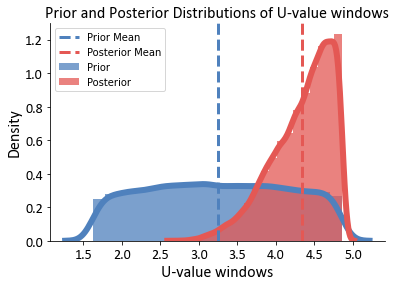

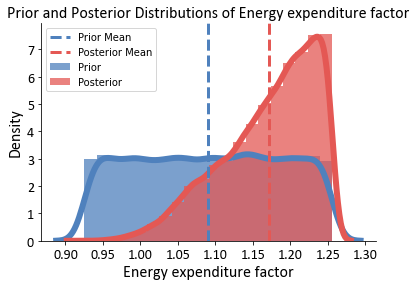

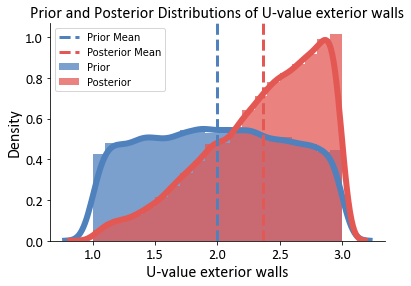

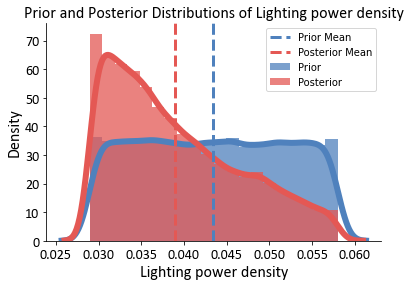

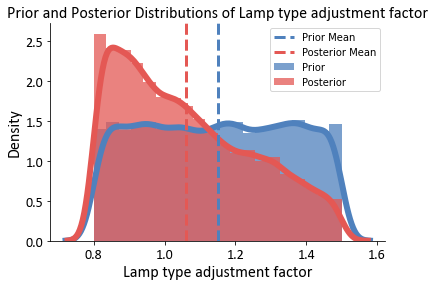

In [5]:
draws = 6400 
tune = 12800 
chains = 4
num_samples_gp = 80
''' Plot Prior & Posterior parameter distributions '''
plots.Plot_PosteriorParam(scr_gebaeude_id, num_bc_param, output_resolution, num_samples_gp, training_ratio, draws, tune, chains)


### Calibrated Model Outputs

In [ ]:

''' Obtain calibrated model - Simulate with posterior parameter probabiliy distirbutions '''
from run_calibModel import run_parallel_simulations

def main():
    if converged:
        df_params, results_df, best_cvrmse, best_r2 = run_parallel_simulations(
        scr_gebaeude_id,
        num_bc_param,
        draws,
        tune,
        chains,
        output_resolution,
        training_ratio,
        start_time,
        end_time,
        climate_file,
        ctrl_file
    )
        
    plots.Plot_CalibratedModel(scr_gebaeude_id, num_bc_param, output_resolution, training_ratio, draws, tune, start_time, end_time)

if __name__ == '__main__':
    mp.freeze_support()
    main()
    



Setting up multiprocessing with 16 processes...
Starting parallel simulations...


Calibrated model outputs with uncertainty is shown in the figure below.
The grey area indicates the years used for the training (calibration) meanwhile the remaining years can be used for the evaluation of the quality of the calibration.


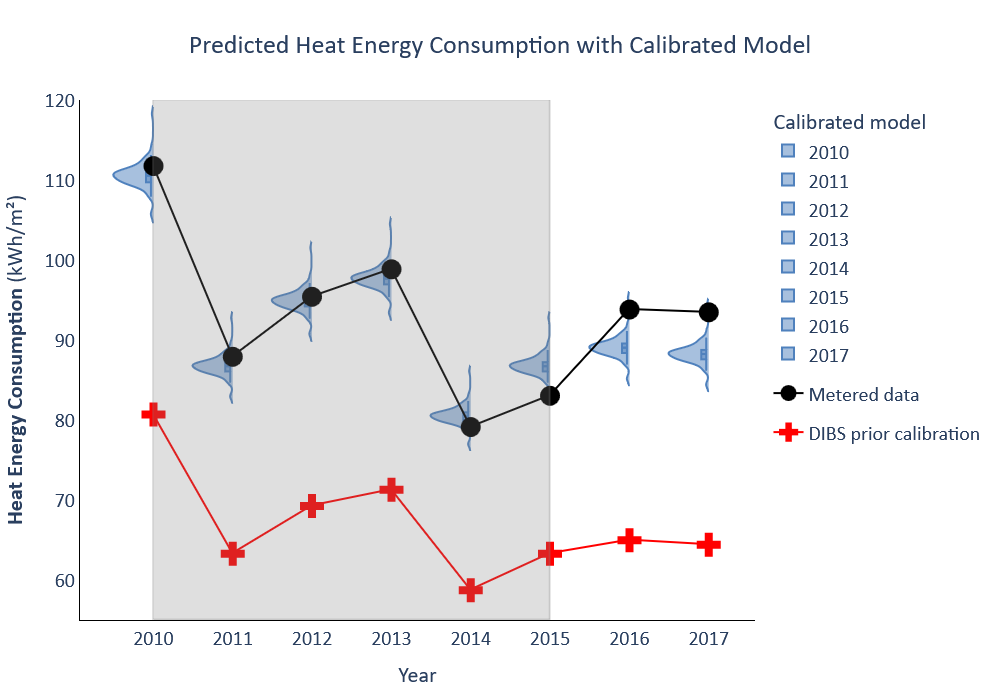

In [9]:
# Plot Calibrated Model
print('Calibrated model outputs with uncertainty is shown in the figure below.\nThe grey area indicates the years used for the training (calibration) meanwhile the remaining years can be used for the evaluation of the quality of the calibration.')
from IPython.display import Image
display(Image(filename=os.path.join(paths.PLOTS_DIR, f'{scr_gebaeude_id}/6_CalibModel_{scr_gebaeude_id}_{output_resolution}_{training_ratio}.png'),width=710, height=500)) 